# Titanic Survival Part 3: Training Classifiers for Accuracy

In Part 1 of this project I conduct Exploratory Data Analysis (EDA) of the Titanic training data using R. This exploration can be found [here.](http://rpubs.com/BigBangData/512981)

In Part 2 I continue the exploration using Python and building a couple of basic models. This is not intended as the goal of the competition, just an exploration of modeling in Python.

In Part 3 (this notebook) I create a pre-processing pipeline and train several models in Python using the scikit-learn module, and submit my predictions to the competition.


In [84]:
from datetime import datetime
import time

dt_object = datetime.fromtimestamp(time.time())
dt_object = str(dt_object).split('.')[0]

Date, Time = dt_object.split(' ')
print('Revised on: ' + Date)

Revised on: 2020-01-05


## Pre-Processing

In [85]:
# import modules
import pandas as pd
import numpy as np

# custom pre-processing module
import processing_pipeline as pp  

# load datasets
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test.csv")

# separate target from predictors in training set
survived_labels = train_data['Survived'].copy()
train_data_nolabel = train_data.drop('Survived', axis=1)

# get processed training data and labels
X = pp.process_train(train_data_nolabel)
y = survived_labels.to_numpy()

## Modeling

### Stochastic Gradient Descent

In [86]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
     
sgd_clf = SGDClassifier(random_state=42)
    
accuracies = cross_val_score(estimator=sgd_clf, X=X, y=y, cv=100)

In [87]:
mn, sd = round(accuracies.mean(),4), round(accuracies.std(),4)
mn, sd

(0.7824, 0.1362)

As seen in the previous notebook, the SDG model is too variable.

### Random Forests

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
import pickle

A grid search shows which are the best parameters for the highest accuracy across a range of values. Here we construct a 20 x 2 x 2 = 80-parameter grid search that explores various numbers of estimators and four main categories of models (bootsrapped or not, gini or entropy as IG criterion):


In [89]:
# load pickled model so as to skip the grid search in future notebook runs
try:
    grid_search = pickle.load(open('./RandomForest_GridSearch.sav', 'rb'))
except FileNotFoundError as e:
    num_estimators = list(range(50,5000,250))
    
    grid_param = {
        'n_estimators': num_estimators,
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False]
    }
    
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=grid_param,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1)
    
    # running the grid search: this takes time...
    grid_search.fit(X,y)
    
    # pickle the model for future ease
    pickle.dump(grid_search, open('./RandomForest_GridSearch.sav', 'wb'))

In [90]:
# best arameters and the best accuracy
grid_search.best_params_ , round(grid_search.best_score_, 4)

({'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 300}, 0.8193)

In [238]:
# exploring the results
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_bootstrap', 'param_criterion', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [239]:
# extracting detailed information per CV fold
cv_res0 = grid_search.cv_results_['split0_test_score']
cv_res1 = grid_search.cv_results_['split1_test_score']
cv_res2 = grid_search.cv_results_['split2_test_score']
cv_res3 = grid_search.cv_results_['split3_test_score']
cv_res4 = grid_search.cv_results_['split4_test_score']

In [240]:
# constructing a main dataframe with the data for plotting the results
param_array = grid_search.cv_results_['params']

bootstraps = []
criteria = []
estimators = []
for i in param_array:
    bootstraps.append(i['bootstrap'])
    criteria.append(i['criterion'])
    estimators.append(i['n_estimators'])

data = pd.DataFrame(list(zip(bootstraps, criteria, estimators, cv_res0, cv_res1, cv_res2, cv_res3, cv_res4))
                    ,columns = ['bootstrap','criterion','n_estimators','cv0','cv1','cv2','cv3','cv4'])

In [96]:
# creating subsets for each of the four categories
boot_gini = data[(data.bootstrap == True)  & (data.criterion == 'gini')].copy()
boot_entr = data[(data.bootstrap == True)  & (data.criterion == 'entropy')].copy()
noot_gini = data[(data.bootstrap == False)  & (data.criterion == 'gini')].copy()
noot_entr = data[(data.bootstrap == False)  & (data.criterion == 'entropy')].copy()

In [241]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def plot_single(df, pos, title):

    x = list(df['n_estimators'])
    
    Ys = list()
    for i in ['cv0','cv1','cv2','cv3','cv4']:
        Ys.append(df[i])
    
    plt.subplot(2, 2, pos)
    plt.title(title)
    plt.axis([0, 5000, .75, .85]) 
    
    for i in range(len(Ys)):
        plt.plot(x, list(Ys[i]))

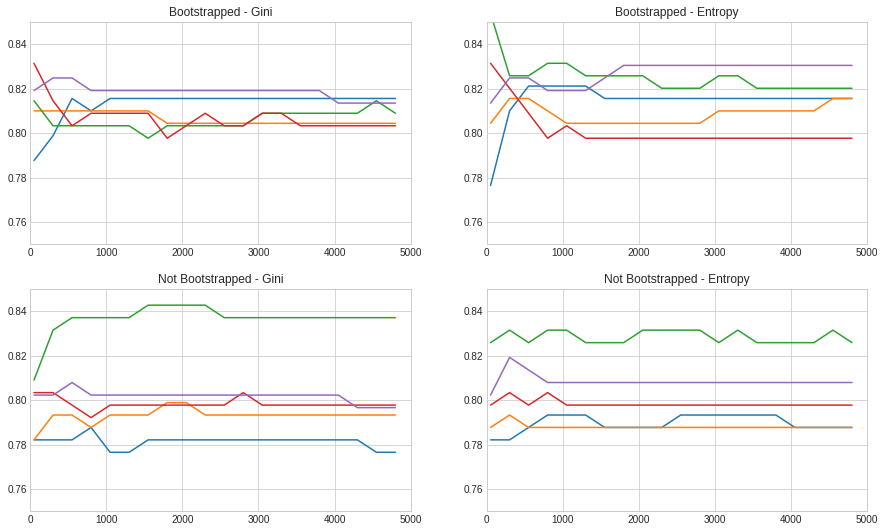

In [242]:
# plotting the details for each category

plt.rcParams['figure.figsize'] = [15, 9]

plot_single(boot_gini, 1, 'Bootstrapped - Gini')
plot_single(boot_entr, 2, 'Bootstrapped - Entropy')
plot_single(noot_gini, 3, 'Not Bootstrapped - Gini')
plot_single(noot_entr, 4, 'Not Bootstrapped - Entropy')

We can see the "story" of each CV fold for each category: 
1. Bootstrapped and Gini - low variance but also low accuracy
2. Bootstrapped and Entropy - mid variance and high accuracy
3. Not Boostrapped and Gini - too much variance
4. Not Boostrapped and Entropy - high variance and perhaps low accuracy

Examining the mean accuracy of all CV folds per category in one comparison plot will be helpful.

In [243]:
def plot_means(df1, df2, df3, df4):

    x = list(df1['n_estimators'])

    plt.axis([0, 5000, .79, .83]) 
    
    Y0 = grid_search.cv_results_['mean_test_score'][:20]
    Y1 = grid_search.cv_results_['mean_test_score'][20:40]
    Y3 = grid_search.cv_results_['mean_test_score'][40:60]
    Y4 = grid_search.cv_results_['mean_test_score'][60:80]
    
    plt.plot(x, Y0, label='Bootstrapped - Gini')
    plt.plot(x, Y1, label='Bootstrapped - Entropy')
    plt.plot(x, Y2, label='Not Bootstrapped - Gini')
    plt.plot(x, Y3, label='Not Bootstrapped - Entropy')
    
    plt.title('Mean Accuracies')
    plt.legend(loc='upper left')

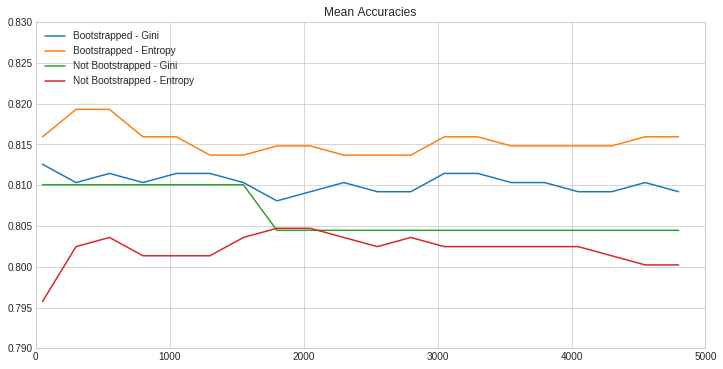

In [244]:
plt.rcParams['figure.figsize'] = [12, 6]
plot_means(boot_gini, noot_gini, boot_entr, noot_entr)

We can confirm that using entropy as the information gain criterion has the highest accuracies when bootstrapping but the lowest when not bootstrapping. 

It also looks as if we will not revisit that plateau of high accuracies around 200-500 number of estimators.

## Feature Selection with Random Forests

While we could stop here and train a classifier using the best parameters we found, it is often useful to verify that the full data is indeed offering the best accuracies, versus models on some optimal subset of the data.

In [11]:
# best model
forest_clf = RandomForestClassifier(bootstrap=True,
                                    criterion='entropy',
                                    n_estimators=300,
                                    random_state=42)

In [13]:
accuracies = cross_val_score(forest_clf, X, y, cv=10)
mn, sd = round(accuracies.mean(),4), round(accuracies.std(),4)
mn, sd

(0.8249, 0.0308)

In [21]:
grid_param = {
    'n_estimators': [x for x in range(200, 410, 10)],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [22]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [23]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bo

In [24]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 290}


In [25]:
best_result = grid_search.best_score_
print(best_result)

0.8204264870931538


In [30]:
grid_param = {
    'n_estimators': [x for x in range(280, 310)],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [31]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=Fa...te=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bootstrap': [T

In [32]:
best_parameters = grid_search.best_params_
best_parameters

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 295}

In [33]:
best_result = grid_search.best_score_
best_result

0.8215488215488216

In [34]:
grid_param = {
    'n_estimators': [295, 1500, 2000, 3000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [35]:

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=grid_param,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [36]:
grid_search.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'bo

In [37]:
grid_search.best_params_ , grid_search.best_score_

{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 295}

In [40]:
means = []
sds = []

for i in [x for x in range(250, 350, 5)]:
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

In [73]:
data = pd.DataFrame(list(zip([x for x in range(250,350,5)], means, sds)), 
             columns=['n_est','means','stdevs'])

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

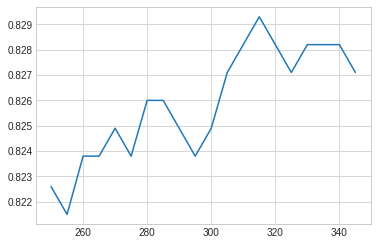

In [102]:
x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

In [103]:
# creating a CI
for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

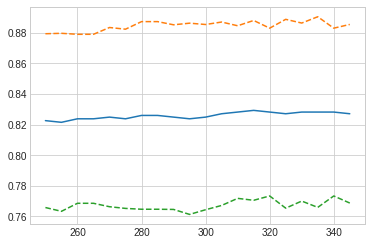

In [104]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')

In [111]:
means = []
sds = []

for i in list(range(100,1100,100)):
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

In [113]:
indices = list(range(100,1100,100))
data = pd.DataFrame(list(zip(indices, means, sds)), 
             columns=['n_est','means','stdevs'])

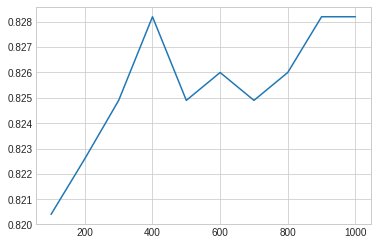

In [115]:
x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

In [116]:
# creating a CI
for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

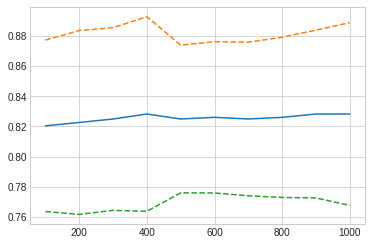

In [117]:
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')

In [4]:
index = list(range(295,6195,295))

means = []
sds = []

for i in index:
    
    forest_clf = RandomForestClassifier(bootstrap=True,
                                        criterion='entropy',
                                        n_estimators=i,
                                        random_state=42)
    
    accuracies = cross_val_score(forest_clf, X, y, cv=10)
    
    means.append(round(accuracies.mean(),4))
    sds.append(round(accuracies.std(),4))

data = pd.DataFrame(list(zip(index, means, sds)), 
             columns=['n_est','means','stdevs'])

for i in range(len(data)):
    data.loc[i, 'upper'] = data.loc[i, 'means'] + 1.965*data.loc[i, 'stdevs']
    data.loc[i, 'lower'] = data.loc[i, 'means'] - 1.965*data.loc[i, 'stdevs']

x = np.array(data['n_est'])
Y = np.array(data['means'])
fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)

fig = plt.figure()
ax = plt.axes()
ax.plot(x, Y)
plt.plot(x, np.array(data['upper']), linestyle='dashed')
plt.plot(x, np.array(data['lower']), linestyle='dashed')